## 1. About the DWD Open Data Portal 

The data of the Climate Data Center (CDC) of the DWD (Deutscher Wetterdienst, German Weather Service) is provided on an **FTP server**. <br> **FTP** stands for _File Transfer Protocol_.

Open the FTP link ftp://opendata.dwd.de/climate_environment/CDC/ in your browser (copy-paste) and find our how it is structured hierarchically.

You can also open the link with **HTTPS** (Hypertext Transfer Protocol Secure): https://opendata.dwd.de/climate_environment/CDC/

We are interested in downloading the metadata of annual temperature to get information related to their stations

In [30]:
import requests
from bs4 import BeautifulSoup
import os
import re # to use regex expressions 
import tqdm
import pandas as pd

# URL of the DWD website
url_base = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/"
url_temporal_resolution = "annual/"
url_parameter = "kl/"
url_subdir = "historical/"
url_full = os.path.join(url_base, url_temporal_resolution, url_parameter, url_subdir)

# Directory to save the downloaded files
download_dir = "./dwd_files/"

# Create the directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

ModuleNotFoundError: No module named 'tqdm'

In [4]:
url_full

'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/'

In [5]:
def grab_file(file_url, download_dir):
        # get only the file name from the full url
        file_name = file_url.split("/")[-1]
        # Download the file
        file_path =os.path.join(download_dir, file_name)
        with open(file_path, "wb") as file:
            file.write(requests.get(file_url).content)
        
    

In [6]:
# Send an HTTP request to the URL
response = requests.get(url_full)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")
    # Look for the metadata file
    links = soup.find_all(href=re.compile("Beschreibung"))
    # Take the url of the file
    file_name = links[0].get("href")
    # Download the file
    grab_file(os.path.join(url_full, file_name), download_dir)
    print(f"Downloaded: {download_dir+file_name}")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")

Downloaded: ./dwd_files/KL_Jahreswerte_Beschreibung_Stationen.txt


In [7]:
# get station path
file_path = os.path.join(download_dir,file_name)
# read the header of the file
header = open(file_path, encoding="latin").readline().split()
header

['Stations_id',
 'von_datum',
 'bis_datum',
 'Stationshoehe',
 'geoBreite',
 'geoLaenge',
 'Stationsname',
 'Bundesland']

In [8]:
#pd.read_csv?

In [9]:
# read the stations dataframe
df_stations = pd.read_fwf(file_path,
                          skiprows=3,
                          names=header,
                          encoding="latin", 
                          parse_dates=["von_datum","bis_datum"],
                          dtype={"Stations_id":str}
                          #index_col="Stations_id"
                         )
df_stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,00003,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,00044,1971-03-01,2022-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,00052,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,00061,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern
4,00070,1973-06-01,1986-09-30,712,48.2052,9.0371,Albstadt-Ebingen,Baden-Württemberg
...,...,...,...,...,...,...,...,...
1191,19631,1881-06-01,1969-12-31,268,50.8083,10.2294,Salzungen,Thüringen
1192,19647,1951-01-01,2005-10-31,178,49.4547,8.9794,Eberbach/Neckar,Baden-Württemberg
1193,19774,1971-08-19,1994-02-28,174,51.4814,10.8057,Nordhausen (Umspannwerk),Thüringen
1194,19781,1881-01-01,1953-12-31,367,48.7429,11.4233,Ingolstadt,Bayern


In [10]:
df_stations.loc[:,"Bundesland"].unique()

array(['Nordrhein-Westfalen', 'Niedersachsen', 'Schleswig-Holstein',
       'Bayern', 'Baden-Württemberg', 'Hessen', 'Brandenburg',
       'Thüringen', 'Mecklenburg-Vorpommern', 'Sachsen',
       'Rheinland-Pfalz', 'Sachsen-Anhalt', 'Berlin', 'Saarland',
       'Bremen', 'Hamburg'], dtype=object)

In [11]:
# filter stations only in NRW which are active and older than 1930
df_stations_short = df_stations.query(
    "(Bundesland == 'Nordrhein-Westfalen') and (bis_datum>=2022) and (von_datum<1950)"
)

In [12]:
df_stations_short

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
113,00555,1925-01-01,2023-10-31,110,51.5026,7.2289,Bochum,Nordrhein-Westfalen
219,01078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
264,01300,1931-01-01,2022-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
265,01303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
266,01327,1937-01-01,2022-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
318,01590,1937-01-01,2022-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
393,02110,1938-01-01,2022-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen
462,02483,1926-11-01,2022-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
467,02497,1937-01-01,2022-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen
491,02629,1851-01-01,2022-12-31,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen


In [13]:
# get the links
links = soup.find_all(href=[re.compile("KL_"+x) for x in df_stations_short.loc[:,"Stations_id"]])
links

[<a href="jahreswerte_KL_00555_19250101_20221231_hist.zip">jahreswerte_KL_00555_19250101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_01078_19400101_20221231_hist.zip">jahreswerte_KL_01078_19400101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_01300_19310101_20221231_hist.zip">jahreswerte_KL_01300_19310101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_01303_18880101_20221231_hist.zip">jahreswerte_KL_01303_18880101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_01327_19370101_20221231_hist.zip">jahreswerte_KL_01327_19370101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_01590_19370101_20221231_hist.zip">jahreswerte_KL_01590_19370101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_02110_19380101_20221231_hist.zip">jahreswerte_KL_02110_19380101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_02483_19261101_20221231_hist.zip">jahreswerte_KL_02483_19261101_20221231_hist.zip</a>,
 <a href="jahreswerte_KL_02497_19370101_20221231_hist.zip">jahreswerte_KL_02497_19370101_20221231_hist.z

In [14]:
try:
    # iterate through the list
    for link in tqdm.tqdm(links):
        # Take the url of the file
        file_name = link.get("href")
        # Download the file
        grab_file(os.path.join(url_full, file_name), download_dir)
    
except:
    print("Failed to download")

print("Download complete")

Failed to download
Download complete


### Which file do I need?
extract one of the zip files to look at the content. Identify which file contains the data you are interested in.

In [15]:
import glob
zip_list = glob.glob(download_dir+"*.zip")
zip_list

['./dwd_files/jahreswerte_KL_00555_19250101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_02497_19370101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_01327_19370101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_01303_18880101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_02110_19380101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_01590_19370101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_01078_19400101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_02483_19261101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_05717_19070101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_04371_19310101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_02968_19030101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_02629_18510101_20221231_hist.zip',
 './dwd_files/jahreswerte_KL_01300_19310101_20221231_hist.zip']

In [16]:
from zipfile import ZipFile
# example of the files inside the first zip file
with ZipFile(zip_list[0]) as myzip:
    print(myzip.namelist())

['Metadaten_Stationsname_Betreibername_00555.html', 'Metadaten_Stationsname_Betreibername_00555.txt', 'Metadaten_Parameter_klima_jahr_00555.html', 'Metadaten_Parameter_klima_jahr_00555.txt', 'Metadaten_Geraete_Lufttemperatur_00555.html', 'Metadaten_Geraete_Lufttemperatur_00555.txt', 'Metadaten_Geraete_Lufttemperatur_Maximum_00555.html', 'Metadaten_Geraete_Lufttemperatur_Maximum_00555.txt', 'Metadaten_Geraete_Lufttemperatur_Minimum_00555.html', 'Metadaten_Geraete_Lufttemperatur_Minimum_00555.txt', 'Metadaten_Geraete_Niederschlagshoehe_00555.html', 'Metadaten_Geraete_Niederschlagshoehe_00555.txt', 'Metadaten_Geraete_Sonnenscheindauer_00555.html', 'Metadaten_Geraete_Sonnenscheindauer_00555.txt', 'Metadaten_Geographie_00555.txt', 'Metadaten_Fehldaten_00555_19250101_20221231.html', 'Metadaten_Fehldaten_00555_19250101_20221231.txt', 'Metadaten_Fehlwerte_00555_19250101_20221231.txt', 'produkt_klima_jahr_19250101_20221231_00555.txt']


In [17]:
with ZipFile(zip_list[0]) as myzip:
    prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
    print(prod_filename)

produkt_klima_jahr_19250101_20221231_00555.txt


In [18]:
with ZipFile(zip_list[0]) as myzip:
    prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
    
    #open just the product file within archive
    with myzip.open(prod_filename) as myfile:
    # read the time series data in a temporal dataframe
        df_temp = pd.read_csv(myfile, 
                      sep=";", 
                      parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], 
                      index_col = "MESS_DATUM_BEGINN", 
                      na_values = [-999.0],
                    dtype={'STATIONS_ID':str}
                         )
df_temp.head()

,STATIONS_ID,MESS_DATUM_ENDE,QN_4,JA_N,JA_TT,JA_TX,JA_TN,JA_FK,JA_SD_S,JA_MX_FX,JA_MX_TX,JA_MX_TN,QN_6,JA_RR,JA_MX_RS,eor
MESS_DATUM_BEGINN,,,,,,,,,,,,,,,,
1925-01-01,555,1925-12-31,5,NaN,9.94,13.33,6.65,NaN,NaN,NaN,NaN,NaN,5.0,911.0,NaN,eor
1926-01-01,555,1926-12-31,5,NaN,10.45,13.69,7.25,NaN,NaN,NaN,NaN,NaN,5.0,1079.0,NaN,eor
1927-01-01,555,1927-12-31,5,NaN,9.71,13.07,6.61,NaN,NaN,NaN,NaN,NaN,5.0,856.0,NaN,eor
1928-01-01,555,1928-12-31,5,NaN,10.00,13.67,6.46,NaN,NaN,NaN,NaN,NaN,5.0,878.0,NaN,eor
1929-01-01,555,1929-12-31,5,NaN,9.37,12.88,5.66,NaN,NaN,NaN,NaN,NaN,5.0,529.0,NaN,eor


In [19]:
# create an empty dataFrame to merge the temperature data to
df_temp = pd.DataFrame()
# iterate through the zipfiles
for zip_file in zip_list:
    with ZipFile(zip_file) as myzip:
        #we are only interested in the file starting with 'produkt_'
        prod_filename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
        
        #open just the product file within archive
        with myzip.open(prod_filename) as myfile:
            # read the time series data in a temporal dataframe
            df_dummy = pd.read_csv(myfile, 
                                  sep=";", 
                                  parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], 
                                  index_col = "MESS_DATUM_BEGINN", 
                                  na_values = [-999.0],
                                  dtype={"STATIONS_ID":str}
                                 )
            # Only interested in the average temperature parameter
            temp_series = df_dummy["JA_TT"].rename(df_dummy["STATIONS_ID"].iloc[0]).to_frame()
            # outer join
            df_temp = pd.merge(df_temp,temp_series,left_index=True, right_index=True, how="outer")

In [20]:
df_temp

,555,2497,1327,1303,2110,1590,1078,2483,5717,4371,2968,2629,1300
MESS_DATUM_BEGINN,,,,,,,,,,,,,
1851-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN
1852-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN
1853-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN
1854-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN
1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01,NaN,9.49,11.60,11.79,11.85,11.86,12.12,7.26,NaN,11.05,12.67,NaN,9.24
2019-01-01,NaN,9.27,11.24,11.44,11.42,11.62,11.84,7.00,10.99,10.89,12.30,11.17,9.00
2020-01-01,NaN,9.70,11.81,11.84,12.06,12.18,12.25,7.28,11.45,11.00,12.84,11.63,9.44


In [21]:
df_temp.index.rename(name='year', inplace=True)
df_temp.head()

,555,2497,1327,1303,2110,1590,1078,2483,5717,4371,2968,2629,1300
year,,,,,,,,,,,,,
1851-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN
1852-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN
1853-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN
1854-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN
1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN


In [22]:
# Replace full datetime with year as integer
try:
    df_temp.set_index(df_temp.index.year, inplace= True) # extract year from index as int
except:
    next
df_temp

,555,2497,1327,1303,2110,1590,1078,2483,5717,4371,2968,2629,1300
year,,,,,,,,,,,,,
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN
1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,NaN,9.49,11.60,11.79,11.85,11.86,12.12,7.26,NaN,11.05,12.67,NaN,9.24
2019,NaN,9.27,11.24,11.44,11.42,11.62,11.84,7.00,10.99,10.89,12.30,11.17,9.00
2020,NaN,9.70,11.81,11.84,12.06,12.18,12.25,7.28,11.45,11.00,12.84,11.63,9.44


In [23]:
mean = df_temp[(df_temp.index >= 1961) & (df_temp.index <= 1990)].mean() # mean annual temp between 1961 and 1990
mean

        555    10.573333
       2497     7.279310
       1327     9.636667
       1303     9.560667
       2110     9.807143
       1590     9.912222
       1078    10.387143
       2483     4.847333
       5717     9.335333
       4371     9.237333
       2968    10.780000
       2629     9.613000
       1300     7.480000
dtype: float64

In [24]:
df_temp_diff = (df_temp - mean)
df_temp_diff

,555,2497,1327,1303,2110,1590,1078,2483,5717,4371,2968,2629,1300
year,,,,,,,,,,,,,
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.883,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.723,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.523,NaN
1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.273,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,NaN,2.21069,1.963333,2.229333,2.042857,1.947778,1.732857,2.412667,NaN,1.812667,1.89,NaN,1.76
2019,NaN,1.99069,1.603333,1.879333,1.612857,1.707778,1.452857,2.152667,1.654667,1.652667,1.52,1.557,1.52
2020,NaN,2.42069,2.173333,2.279333,2.252857,2.267778,1.862857,2.432667,2.114667,1.762667,2.06,2.017,1.96


In [25]:
df_temp_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 1851 to 2022
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0           555  60 non-null     float64
 1          2497  73 non-null     float64
 2          1327  81 non-null     float64
 3          1303  127 non-null    float64
 4          2110  60 non-null     float64
 5          1590  67 non-null     float64
 6          1078  58 non-null     float64
 7          2483  77 non-null     float64
 8          5717  107 non-null    float64
 9          4371  87 non-null     float64
 10         2968  117 non-null    float64
 11         2629  166 non-null    float64
 12         1300  84 non-null     float64
dtypes: float64(13)
memory usage: 18.1 KB


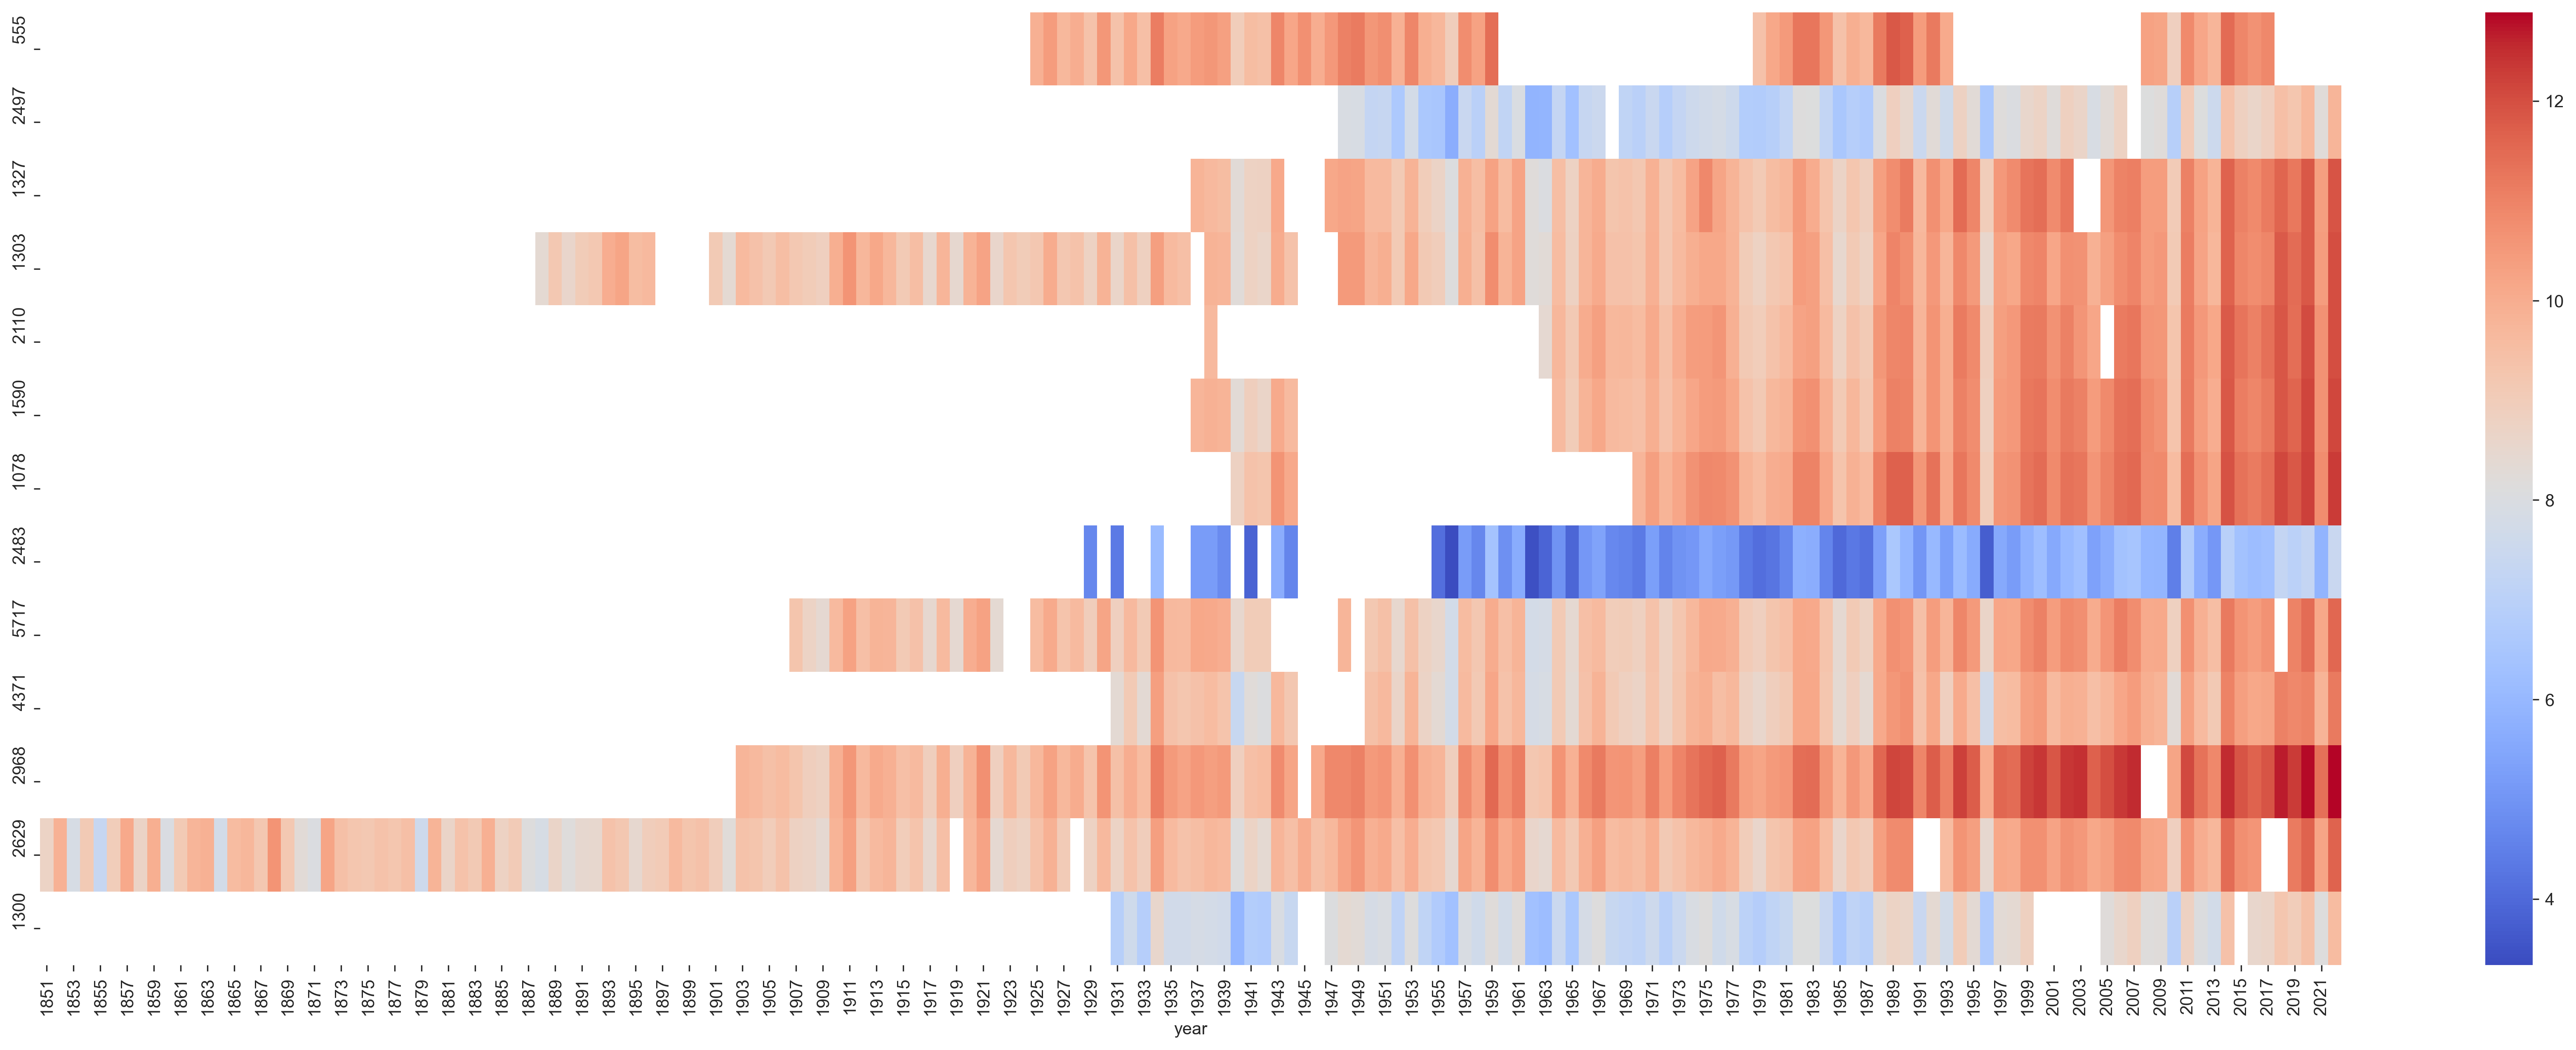

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 300, figsize = (30,10))

sns.heatmap(df_temp.T, cmap='coolwarm', ax = ax1)
fig1.savefig('NRW_Annual_Temp_Stripes_01.png')

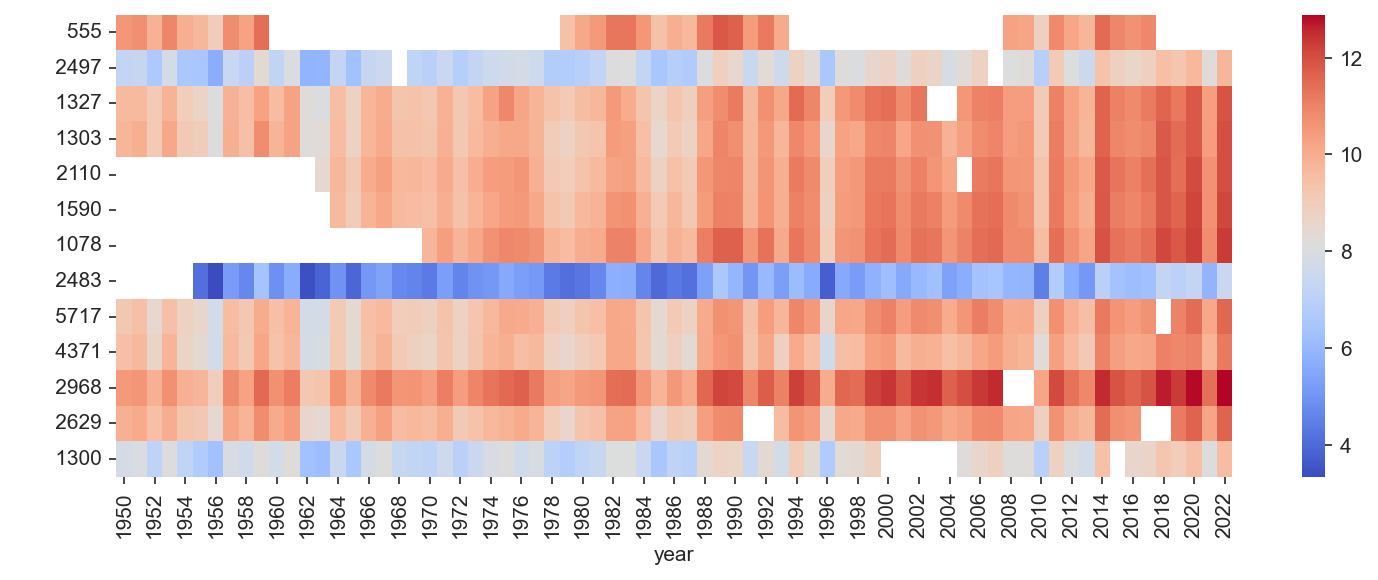

In [27]:
# plot
sns.set_style('ticks')
fig2, ax2 = plt.subplots(dpi = 150, figsize = (12,4))

sns.heatmap(df_temp[df_temp.index >= 1950].T, cmap='coolwarm', ax = ax2)
fig2.savefig('NRW_Annual_Temp_Stripes_02.png')

In [28]:
df_stations_short.filter(like="Stations")

,Stations_id,Stationshoehe,Stationsname
113,00555,110,Bochum
219,01078,37,Düsseldorf
264,01300,351,Eslohe
265,01303,150,Essen-Bredeney
266,01327,147,Weilerswist-Lommersum
318,01590,37,Geldern-Walbeck
393,02110,57,Heinsberg-Schleiden
462,02483,839,Kahler Asten
467,02497,505,Kall-Sistig
491,02629,46,Kleve


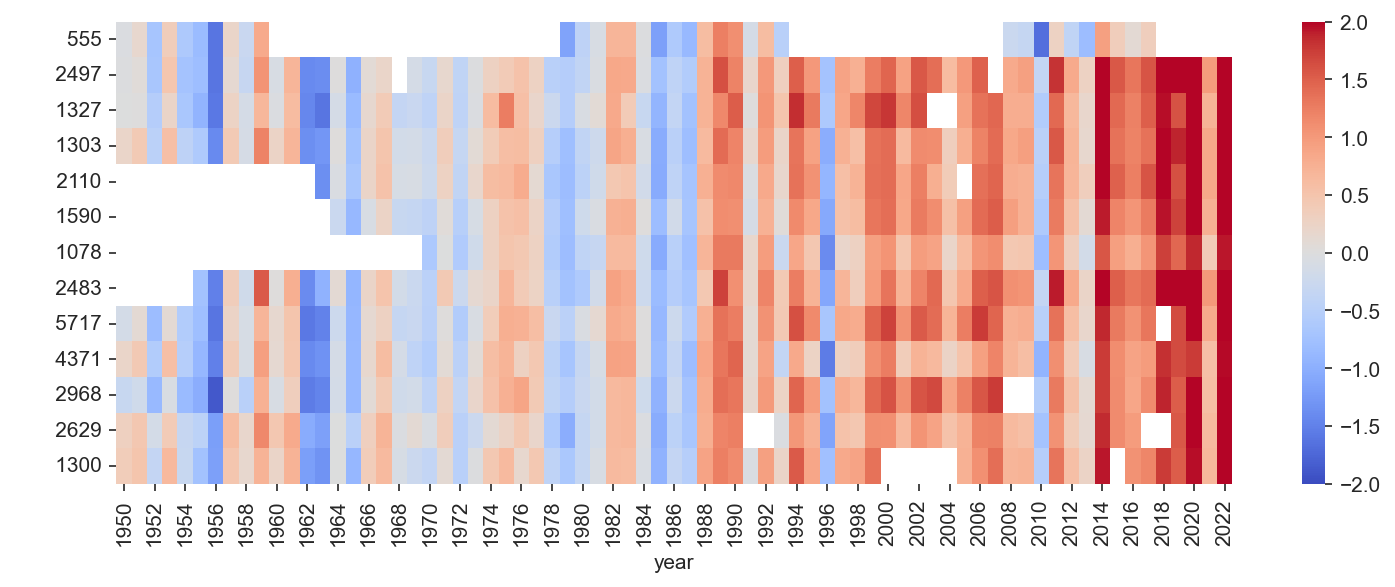

In [29]:
# plot
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 150, figsize = (12,4))

sns.heatmap(df_temp_diff[df_temp_diff.index >= 1950].T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax3)
fig3.savefig('NRW_Annual_Temp_Diff_Stripes_02.png')